In [340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning


from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.express as px

import warnings

import seaborn as sns




In [341]:
data_t = pd.read_csv('prison_2010.txt', delimiter='\t', skiprows=2)
data_t = data_t.drop(range(53,58))

for col in data_t.columns:
   if not (data_t[col].apply(lambda x: isinstance(x, str))).all():
       continue
   
   if (data_t[col].apply(lambda x: isinstance(x, str)).all() & data_t[col].str.contains(',')).any():
        try:
            data_t[col] = data_t[col].replace('[\$,]', '', regex=True).astype(float)
        except AttributeError as err:
            print([col])
            break   
data_t = data_t.iloc[1:, :]

In [342]:
def processData(data, flag=False):
    df = data.iloc[:, 2:]
    # Create a boolean mask of NaN values
    nan_mask = df.isnull()

    # Check for any NaN values in each row
    nan_in_row = nan_mask.any(axis=1)

    # Check for any NaN values in each column
    nan_in_col = nan_mask.any(axis=0)
    rows_with_nans = df[nan_in_row]
    cols_with_nans = df.loc[:, nan_in_col]
    if flag:
        print("Features Containing NaN:", cols_with_nans)
    
    # Drop columns with NaN values and filter out columns containing "Population"
    # df = df.drop(columns=cols_with_nans).filter(regex='^(?!.*(Population)).*')
    df = df.drop(columns=cols_with_nans)



    # Add Percentages to DataFrame
    percent_men = getPercentage(df)[0]
    percent_women= getPercentage(df)[1]
    percent_both= getPercentage(df)[2]
    
    df = pd.concat([df, percent_men, percent_women, percent_both], axis=1)
    
    # Standardize the numerical features
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    scaler = StandardScaler()
    df_std = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols, index=df.index)
    df[df_std.columns] = df_std

    
    return df

def getX(df):
       X = df.iloc[:, 2:]
       return X

def runKmeans(data, X, n):
    kmeans = KMeans(n_clusters=n, init = 'k-means++', n_init=10)
    kmeans.fit(X)
    cluster_data = data.copy() 
    cluster_data['Cluster'] = kmeans.labels_
    return cluster_data


def createBarChart(cluster_data, x_axis="Geography", y_axis="empty"): 
    fig = px.bar(cluster_data, x=x_axis, y=y_axis, color='Cluster')
    fig.show()

def stateClusterGraph(cluster_data):
    state_abbreviations = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
    }
    cluster_data['State Abbreviation'] = cluster_data['Geography'].map(state_abbreviations)


    # Create a choropleth map
    fig = px.choropleth(cluster_data, locations='State Abbreviation', locationmode='USA-states', color='Cluster', scope='usa', title='Clusters by State')

    # fig.show()
    return fig


def elbow_method(df, n):
    # Create a new DataFrame with only the columns you want to use for clustering
    X = df.iloc[:,1:6]

    # Perform K-means clustering for different values of K
    inertias = []
    for k in range(1, n):
        kmeans = KMeans(n_clusters=k, init = 'k-means++' , random_state=42, n_init=10).fit(X)
        inertia = kmeans.inertia_
        inertias.append(inertia)

    # Plot the elbow curve to choose the optimal value of K
    plt.plot(range(1, n), inertias, 'bx-')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal K')
    plt.show()

    # create dataframe for elbow plot data
    elbow_data = pd.DataFrame({
        'K': range(1, n),
        'Inertia': inertias
    })
    elbow_data = elbow_data.set_index('K')

    # print(elbow_data)

    # Calculate the slope and second derivative of the inertia curve
    slopes = [inertias[i+1] - inertias[i] for i in range(len(inertias)-1)]
    second_derivatives = [slopes[i+1] - slopes[i] for i in range(len(slopes)-1)]

    # Find the index of the maximum second derivative
    max_index = second_derivatives.index(max(second_derivatives))

    # The optimal value of K is one more than the index of the maximum second derivative
    best_k = max_index + 2
    # print(best_k)

    # return df, elbow_data, inertias, best_k


def correlationMap(df):
    # Select only the numeric columns
    numeric_columns = df.select_dtypes(include=['int64', 'float64'])
    
    # Calculate the correlation matrix
    corr_matrix = numeric_columns.corr()
    
    # Set the upper triangle to NaN
    corr_matrix = corr_matrix.where(np.tril(np.ones(corr_matrix.shape)).astype(np.bool))
    np.fill_diagonal(corr_matrix.values, np.nan)

    
    # Create a heatmap using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
    plt.title('Correlation of Numeric Features')
    plt.show()

def visualizing_results_2d(df, n):
    # Create a new DataFrame with only the columns you want to use for clustering
    X = df[['Incarceration rate', 'Female incarceration rate', 'Male incarceration rate']]

    # Create a KMeans instance with k = 3
    kmeans = KMeans(n_clusters=n, init = 'k-means++', n_init=10)
    # Fit the model to the data
    kmeans.fit(X)
    # Get the cluster assignments for each data point
    df['Cluster'] = kmeans.labels_

    # Get the cluster centroids
    centroids = kmeans.cluster_centers_

    # Create an empty figure
    fig = make_subplots(rows=3, cols=1, subplot_titles=(
        "IR by FIR", "IR by MIR", "FIR by MIR"))

    # Add a scatter plot of the data points to the first subplot
    fig.add_trace(
        go.Scatter(
            x=df['Incarceration rate'],
            y=df['Female incarceration rate'],
            mode='markers',
            marker=dict(
                color=df['Cluster']
            ),
            showlegend=False
        ),
        row=1,
        col=1
    )

    # Add a scatter plot of the centroids to the first subplot
    fig.add_trace(
        go.Scatter(
            x=centroids[:, 1],
            y=centroids[:, 0],
            mode='markers',
            marker=dict(
                size=10,
                color='red',
                symbol='star',
                line=dict(
                    width=1,
                    color='black'
                )
            ),
            name='Centroids'
        ),
        row=1,
        col=1
    )

    # Add a scatter plot of word_id by counts to the second subplot
    fig.add_trace(
        go.Scatter(
            x=df['Incarceration rate'],
            y=df['Male incarceration rate'],
            mode='markers',
            marker=dict(
                color=df['Cluster']
            ),
            showlegend=False
        ),
        row=2,
        col=1
    )

    # Add a scatter plot of doc_id by counts to the third subplot
    fig.add_trace(
        go.Scatter(
            x=df['Female incarceration rate'],
            y=df['Male incarceration rate'],
            mode='markers',
            marker=dict(
                color=df['Cluster']
            ),
            showlegend=False
        ),
        row=3,
        col=1
    )

    # Update the layout of the figure
    fig.update_layout(
        height=900,
        xaxis=dict(
            title='Incarceration rate'
        ),
        xaxis2=dict(
            title='Incarceration rate'
        ),
        xaxis3=dict(
            title='Female incarceration rate'
        ),
        yaxis=dict(
            title='Female incarceration rate'
        ),
        yaxis2=dict(
            title='Male incarceration rate'
        ),
        yaxis3=dict(
            title='Male incarceration rate'
        ),
        title='Clusters'
    )

    # Show the figure
    fig.show()

def getCorrectionalPopulation(df):
    # Use filter and regex pattern to separate columns into their own dataframes

    # filter columns based on gender
    male_cols = df.filter(regex='(Total Men|: Men$)').columns.tolist()
    female_cols = df.filter(regex='(Total Women|: Women$)').columns.tolist()
    both_cols = df.filter(regex='(: In Correctional Facilities for Adults|: in Correctional Facilities for Adults$)').columns.tolist()


    df_male = df[male_cols]
    df_female = df[female_cols]
    df_both = df[both_cols]


    drop_men_women = [col for col in df_both.columns if 'Men' in col or 'Women' in col]
    df_both = df_both.drop(drop_men_women, axis=1)

    return df_male, df_female, df_both

def getPercentage(df):
    corr_men = getCorrectionalPopulation(df)[0]
    corr_women = getCorrectionalPopulation(df)[1]
    corr_both = getCorrectionalPopulation(df)[2]
    percent_men = corr_men.div(df['Total Population: Male'], axis=0)*100
    percent_men.columns = ['Percent ' + col for col in percent_men.columns]

    percent_women = corr_women.div(df['Total Population: Female'], axis=0)*100
    percent_women.columns = ['Percent ' + col for col in percent_women.columns]

    percent_both = corr_both.div(df['Total Population'], axis=0)*100
    percent_both.columns = ['Percent ' + col for col in percent_both.columns]
    return percent_men, percent_women, percent_both

def getPopulation(df):
    # Use filter and regex pattern to separate columns into their own dataframes

    # filter columns based on gender
    male_cols = df.filter(regex=': Male$').columns.tolist()
    female_cols = df.filter(regex=': Female$').columns.tolist() 
    both_cols = df.filter(regex=': in Correctional Facilities for Adults$').columns.tolist()

    # create dataframes for male, female, and both
    df_male = df[male_cols]
    df_female = df[female_cols]
    df_both = df[both_cols]


In [343]:
df  = processData(data_t)

In [344]:
# correlationMap(processData(data_t))

In [345]:
# Data frames that onyl consider Incarceration rates
rate_df_whole =processData(data_t).filter(regex='^(?!.*(Correctional|Percent|Population)).*') 
rate_df_total = rate_df_whole.filter(regex='^(?!.*([Mm]ale)).*') # Total rates
rate_df_male = rate_df_whole.filter(regex='.*(Geography|Male).*') # Male rates
rate_df_female = rate_df_whole.filter(regex='.*(Geography|[Fem]ale).*') # Female rates



In [346]:
rate_df_total.columns

Index(['Geography', 'Incarceration rate', 'Incarceration rate: White alone',
       'Incarceration rate: Black or African American alone',
       'Incarceration rate: American Indian and Alaska Native alone',
       'Incarceration rate: Asian alone',
       'Incarceration rate: Native Hawaiian and other Pacific Islander alone',
       'Incarceration rate: Some other race alone',
       'Incarceration rate: Two or more races',
       'Incarceration rate: Hispanic or Latino',
       'Incarceration rate: White alone, not Hispanic or Latino'],
      dtype='object')

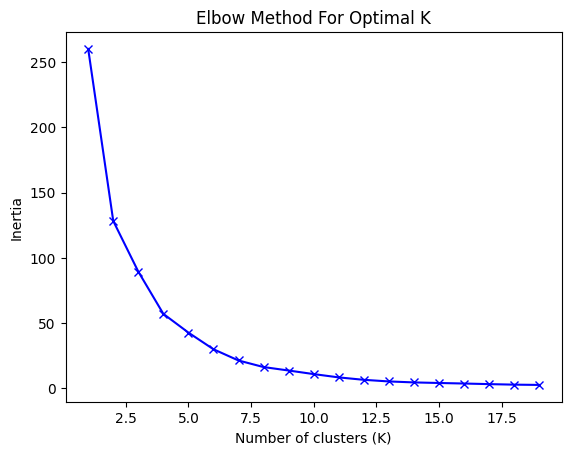

In [347]:
elbow_method(df, 20) ## Used to determine best k for K-means

In [348]:
n=4

In [349]:
visualizing_results_2d(processData(data_t),n)

In [350]:
# Get graphs with State abbrevations assigned for each
total_rate_fig = stateClusterGraph(runKmeans(rate_df_total, getX(rate_df_total), n)) 
male_rate_fig= stateClusterGraph(runKmeans(rate_df_male, getX(rate_df_male), n))
female_rate_fig = stateClusterGraph(runKmeans(rate_df_female, getX(rate_df_female), n))

In [351]:
# Make 3 subplots for 
# Create a 1x3 grid of subplots with titles and a geo subplot type
fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=('Total Rate', 'Male Rate', 'Female Rate'),
    specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}]]
)

# Add your figures as subplots
fig.add_trace(total_rate_fig.data[0], row=1, col=1)
fig.add_trace(male_rate_fig.data[0], row=1, col=2)
fig.add_trace(female_rate_fig.data[0], row=1, col=3)

# Update the geo attribute of each subplot to set the scope to 'usa'
fig.update_geos(scope='usa')

# Update the layout to show the subplots
fig.update_layout(title='Clusters by State')

fig.show()

In [352]:
full  = processData(data_t)
stateClusterGraph(runKmeans(full, getX(full), n))

In [353]:
createBarChart(runKmeans(full, getX(full), n), x_axis="Geography", y_axis='Total : In Correctional Facilities for Adults')
